# Calibration of household transmissions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from scipy.special import gamma
from os.path import join
from tqdm import tqdm_notebook as tqdm
from scipy.stats import linregress

## Age dependent secondary attack rate

According to a recent meta study [Zachary et al. 2020](https://jamanetwork.com/journals/jamanetworkopen/fullarticle/2774102), household secondary attack rate to adult contacts is $\text{SAR}_\text{literature}=28.3$ % (average of symptomatic and asymptomatic index cases). To calibrate the base transmission risk $\beta$ between two agents in a household, we simulate household transmissions for our setting in which the transmission risk is declining with infection duration and agents have a given probability to develop a symptomatic course.

According to a cohort study from Italy [Poletti et al. 2020](https://jamanetwork.com/journals/jamanetworkopen/fullarticle/2777314) (table 1), the probability to have a symptomatic course strongly depends on age. The probabilities reported for the relevant age brackets (adults) are:
* 20-39 years old: 22.41%
* 40-59 years old: 30.51%
* 60-79 years old: 35.46%
* older than 80 years: 64.56%

Since the household secondary attack rates reported by Zachary et al. are averaged over all adult age brackets, we need to make an assumption about the underlying age distribution of the population. The studies incorporated in the Zachary et al. metastudy are predominantly from populations in Europe, China and South Korea, as these were the regions primarily affected by the spread of SARS-CoV-2 at the time the study was published: 

In [134]:
target_attack_rate = 0.283

### Study index case contributions

In [100]:
# number of index cases per study
studies_europe = 13309 + 347 + 179 + 1489 + 365 + 990 + 453 + 141 + 54
studies_china = 391 + 157 + 100 +135 + 1178 + 314 + 349 + 105 + 1158 + 148 + 85 + 585 \
         + 41 + 25 + 35 + 144 + 31 + 560 + 359 + 11 + 283
studies_south_korea = 57 + 10 + 107 + 30 + 10 + 5706 + 97 + 108
studies_other = 10 + 19 + 637 + 26 + 18 + 28 + 181 + 998 + 58 + \
         69 + 25 + 229 + 74 + 32 + 223

print('europe: ', studies_europe)
print('china: ', studies_china)
print('south korea: ', studies_south_korea)
print('other: ', studies_other)

europe:  17327
china:  6194
south korea:  6125
other:  2627


Data for the population age distributions from 2020 for Europe, China and South Korea are accesible [at the UN data hub](https://population.un.org/wpp/Download/Standard/Population/) (see "Population proportion calculation" below). 

| region | age group | proportion |
| ------ | --------- | -----------|
| Europe | 20-39 | 25.3% |
| Europe | 40-59 | 27.9% |
| Europe | 60-79 | 20.4% |
| Europe | 80+ | 5.3% |
| ------ | --------- | -----------|
| China | 20-39 | 28.8% |
| China | 40-59 | 30.5% |
| China | 60-79 | 15.5% |
| China | 80+ | 1.8% |
| ------ | --------- | -----------|
| South Korea | 20-39 | 26.9% |
| South Korea | 40-59 | 32.6% |
| South Korea | 60-79 | 19.5% |
| South Korea | 80+ | 3.6% |

If we weight the population age group ratios of the individual regions (adjusted ratios) by the number of index cases they contributed to the meta-study, we can approximate the underlying population distribution for the secondary attack rates reported in Zachary et al. This is only a coarse approximation, because we do not consider other factors such as possible bias or uncertainties when calculating the adjusted population ratios.

### Weight adjusted population age group ratios

In [121]:
# population distributions weighted by number of index cases contributed to the meta-study
europe_w = 17327 / (17327 + 6194 + 6125)
china_w = 6194 / (17327 + 6194 + 6125)
south_korea_w = 6125 / (17327 + 6194 + 6125)

prop_20_to_39 = 25.3 * europe_w + 28.8 * china_w + 26.9 * south_korea_w
prop_40_to_59 = 27.9 * europe_w + 30.5 * china_w + 32.6 * south_korea_w
prop_60_to_79 = 20.4 * europe_w + 15.5 * china_w + 91.5 * south_korea_w
prop_80_plus = 5.3 * europe_w + 1.8 * china_w + 3.6 * south_korea_w

# upscaled population distributions
all_prop = prop_20_to_39 + prop_40_to_59 + prop_60_to_79 + prop_80_plus
prop_20_to_39 /= all_prop
prop_40_to_59 /= all_prop
prop_60_to_79 /= all_prop
prop_80_plus /= all_prop

age_group_distribution = [prop_20_to_39, prop_40_to_59, prop_60_to_79, prop_80_plus]

print('20 to 39: {:1.2f}%'.format(prop_20_to_39 * 100))
print('40 to 59: {:1.2f}%'.format(prop_40_to_59 * 100))
print('60 to 79: {:1.2f}%'.format(prop_60_to_79 * 100))
print('80+: {:1.2f}%'.format(prop_80_plus * 100))

20 to 39: 28.03%
40 to 59: 31.27%
60 to 79: 36.22%
80+: 4.48%


### Population proportion calculation

In [64]:
pop = pd.read_csv('/home/jana/Documents/WPP2019_POP_F07_1_POPULATION_BY_AGE_BOTH_SEXES.csv',
                  decimal=',')

for col in age_cols:
    pop[col] = pop[col].apply(lambda x: x.replace(' ', ''))
    pop[col] = pop[col].replace({'...':np.nan})
    pop[col] = pop[col].astype(float)
    
age_cols = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39',
       '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79',
       '80-84', '85-89', '90-94', '95-99', '100+']

age_20_to_39 = ['20-24', '25-29', '30-34', '35-39']
age_40_to_59 = ['40-44', '45-49', '50-54', '55-59']
age_60_to_79 = ['60-64', '65-69', '70-74', '75-79']
age_80_plus = ['80-84', '85-89', '90-94', '95-99', '100+']

In [92]:
europe_pop = pop[(pop['Region, subregion, country or area *'] == 'EUROPE') &\
                 (pop['Reference date (as of 1 July)'] == 2020)].copy()
europe_N = europe_pop[age_cols].sum(axis=1).values[0]
europe_pop = europe_pop[age_cols] / europe_N

In [93]:
print('20 to 39:', europe_pop[age_20_to_39].sum(axis=1).values[0] * 100)
print('40 to 59:', europe_pop[age_40_to_59].sum(axis=1).values[0] * 100)
print('60 to 79:', europe_pop[age_60_to_79].sum(axis=1).values[0] * 100)
print('80+:', europe_pop[age_80_plus].sum(axis=1).values[0] * 100)

20 to 39: 25.323854554695806
40 to 59: 27.892621399479694
60 to 79: 20.356323607107747
80+: 5.298574839326676


In [95]:
china_pop = pop[(pop['Region, subregion, country or area *'] == 'China') &\
                 (pop['Reference date (as of 1 July)'] == 2020)].copy()
china_N = china_pop[age_cols].sum(axis=1).values[0]
china_pop = china_pop[age_cols] / china_N

In [96]:
print('20 to 39:', china_pop[age_20_to_39].sum(axis=1).values[0] * 100)
print('40 to 59:', china_pop[age_40_to_59].sum(axis=1).values[0] * 100)
print('60 to 79:', china_pop[age_60_to_79].sum(axis=1).values[0] * 100)
print('80+:', china_pop[age_80_plus].sum(axis=1).values[0] * 100)

20 to 39: 28.761924877181844
40 to 59: 30.451608151888077
60 to 79: 15.504442018921393
80+: 1.849341669659972


In [80]:
korea_pop = pop[(pop['Region, subregion, country or area *'] == 'Republic of Korea') &\
    (pop['Reference date (as of 1 July)'] == 2020)].copy()
korea_N = korea_pop[age_cols].sum(axis=1).values[0]
korea_pop = korea_pop[age_cols] / korea_N

In [89]:
print('20 to 39:', korea_pop[age_20_to_39].sum(axis=1).values[0] * 100)
print('40 to 59:', korea_pop[age_40_to_59].sum(axis=1).values[0] * 100)
print('60 to 79:', korea_pop[age_60_to_79].sum(axis=1).values[0] * 100)
print('80+:', korea_pop[age_80_plus].sum(axis=1).values[0] * 100)

20 to 39: 26.907097856404455
40 to 59: 32.56548791667479
60 to 79: 19.534221459361405
80+: 3.620121320876163


## Transmission risk modification due to infection progression

In our simulation, the base transmission risk is multiplied with a modifier $m(\text{day})$, which is 1 until symptom onset and then linearly decreases until it reaches zero at the time that corresponds to the infection duration (as depicted below).

In [3]:
def get_transmission_risk_time_modifier(exposure_duration, time_until_symptoms,
                                       infection_duration, days_since_exposure):
    '''
    Given an agents exposure duration, time until symptom onset and infection
    duration, returns the modifier to the transmission risk, based on the 
    progression of the infection (days since exposure).
    '''
    asymptomatic_infectious = time_until_symptoms - exposure_duration
    
    try:
        modifier = 1 - max(0, days_since_exposure - asymptomatic_infectious) / \
                    (infection_duration - asymptomatic_infectious)
    except ZeroDivisionError:
        return 1
    return modifier

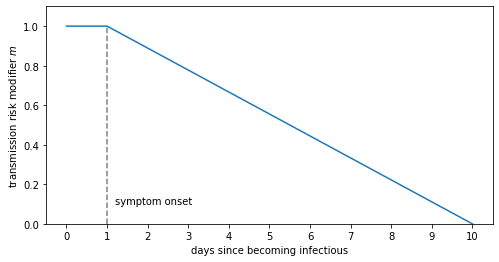

In [4]:
# illustration of the decline of transmission risk with infection progression
infection_duration = 10
exposure_duration = 5
time_until_symptoms = 6
asymptomatic_infectious = time_until_symptoms - exposure_duration

x = np.arange(0, infection_duration + 1)
y = [get_transmission_risk_time_modifier(exposure_duration, time_until_symptoms,
                                         infection_duration, i) for i in x]

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x, y)
ax.plot([asymptomatic_infectious, asymptomatic_infectious], [0, 1],
        '--', color='grey')
ax.text(asymptomatic_infectious + 0.2, 0.1, 'symptom onset')
ax.set_xticks(x)
ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.set_ylabel('transmission risk modifier $m$')
ax.set_xlabel('days since becoming infectious')
ax.set_ylim(0, 1.1);

## Base transmission risk calibration

To calibrate the base transmission risk $\beta$, we implement the following steps:
1. We create two agents with epidemiological parameters (exposure time, time until symptoms, infection duration) drawn from the random distributions used for the simulation study, and an age drawn from the adjusted population age distribution. The probability to have a symptomatic course depends on the agent's age.
2. We define one of the two individuals as the index case and simulate a number of days equal to the infection duration of the index case. The transmissibility of the index case is adjusted by whether or not the agent has a symptomatic course. On every day, the other agent has a chance of $\beta \cdot m(\text{day})$ of becoming infected. We ignore a possible dependence of susceptibility on age, as evidence for this effect is still inconclusive.
3. We repeat this simulation a number of times and calculate the secondary attack rate $\text{SAR}_\text{simulation}$ as the average of the number of times the second agent has become infected.

We vary $\beta$ for a range of realistic values and repeat steps 1-3. We then chose the value for $\beta$ that minimizes $|\text{SAR}_\text{literature} - \text{SAR}_\text{simulation}|$. 

In [150]:
### helper functions
def weibull_two_param(shape, scale):
    '''
    Scales a Weibull distribution that is defined soely by its shape.
    '''
    return scale * np.random.weibull(shape)

def get_epi_params():
    '''
    Gets a combination of exposure duration, time until symptom onset and
    infection duration that satisfies all conditions.
    '''
    # scale and shape of Weibull distributions defined by the following means
    # and variances
    # exposure_duration = [5, 1.9] / days
    # time_until_symptoms = [6.4, 0.8] / days
    # infection_duration = [10.91, 3.95] / days
    epi_params = {
        'exposure_duration': [2.8545336526034513, 5.610922825244271],
        'time_until_symptoms': [9.602732979535194, 6.738998146675984],
        'infection_duration': [3.012881111335679, 12.215213280459125]}  

    tmp_epi_params = {}
    # iterate until a combination that fulfills all conditions is found
    while True:
        for param_name, param in epi_params.items():
            tmp_epi_params[param_name] = \
                round(weibull_two_param(param[0], param[1]))

        # conditions
        if tmp_epi_params['exposure_duration'] > 0 and \
           tmp_epi_params['time_until_symptoms'] >= \
           tmp_epi_params['exposure_duration'] and\
           tmp_epi_params['infection_duration'] > \
           tmp_epi_params['exposure_duration']:
           
            return tmp_epi_params


def check_symptomatic_course(age_group_distribution):
    '''
    Determines, wheter an agent will have a symptomatic course
    '''
    # draw the agent's age group from the adjusted 
    age_group = np.random.choice(['20_to_39', '40_to_59', '60_to_79', '80+'],
                p=age_group_distribution)
    symptom_probabilities = {
        '20_to_39':0.2241,
        '40_to_59':0.3051,
        '60_to_79':0.3546,
        '80+':0.6456
    }  
    # get the probability for a symptomatic course from the age group
    symptom_probability = symptom_probabilities[age_group]
    
    # determine wheter the disease course is symptomatic, based on the symptom
    # probability
    symptomatic_course = False
    if np.random.random() < symptom_probability:
        symptomatic_course = True
        
    return symptomatic_course

In [194]:
### household transmission simulation
data_dst = '../data/calibration_results'
fname = 'household_transmission_base_risk_scan_{}.csv'.format(len(runs))
runs = range(0, 10000)

# grid from which base transmission risks are sampled
base_transmission_risks = np.arange(0.06, 0.08, 0.001)
results = pd.DataFrame()
results['transmission'] = [np.nan] * len(runs) * len(base_transmission_risks)
iterables = [base_transmission_risks, runs]
index = pd.MultiIndex.from_product(iterables, \
                    names=['base_transmission_risk', 'run'])
results.index = index

with tqdm(total=len(base_transmission_risks) * len(runs)) as pbar:
    for base_trans_risk in base_transmission_risks:
        for run in runs:
            infected = get_epi_params()
            transmission_occured = 0

            # Note: starts at day 1, to reflect the simulation implementation
            for day in range(1, infected['infection_duration'] + 1):
                time_modifier = get_transmission_risk_time_modifier(\
                    infected['exposure_duration'], infected['time_until_symptoms'],
                    infected['infection_duration'], day)
                
                sympt_modifier = 1
                if not check_symptomatic_course(age_group_distribution):
                    sympt_modifier = 0.6
                    
                mod_trans_risk = 1 - base_trans_risk * time_modifier * sympt_modifier
                transmission = np.random.random()
                if transmission > mod_trans_risk:
                    transmission_occured = 1
                    break

            results.loc[base_trans_risk, run]['transmission'] = \
            transmission_occured
            pbar.update(1)

# save simulation results
results = results.reset_index()
results.to_csv(join(data_dst, fname), index=False)

<ipython-input-194-f005a5edcabf>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=len(base_transmission_risks) * len(runs)) as pbar:


  0%|          | 0/210000 [00:00<?, ?it/s]

In [198]:
# load and aggregate simulation results
results = pd.read_csv(join(data_dst, fname))
results_mean = results[['base_transmission_risk', 'transmission']]\
    .groupby('base_transmission_risk')\
    .agg({'transmission':['mean', 'std']})
results_mean.head(3)

transmission          
                               mean       std
base_transmission_risk                       
0.060                        0.2373  0.425449
0.061                        0.2426  0.428677
0.062                        0.2467  0.431112

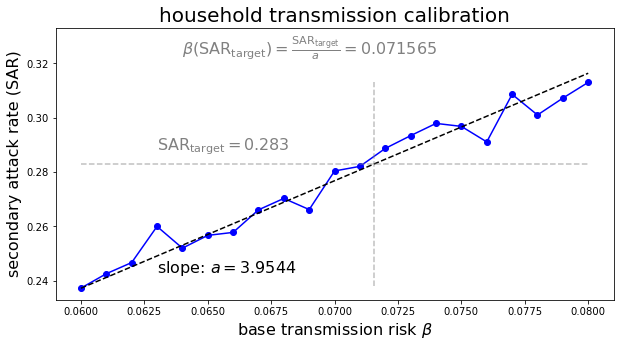

In [247]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(results_mean.index, results_mean['transmission']['mean'], 'o-', color='b')

# regression with zero intercept
x = results_mean.index.values
x = x[:, np.newaxis]
y = results_mean['transmission']['mean'].values
slope, _, _, _ = np.linalg.lstsq(x, y, rcond=None)
slope = slope[0]

ax.plot(results_mean.index, slope * results_mean.index, '--', color='k')
ax.set_xlabel('base transmission risk $\\beta$', fontsize=16)
ax.set_ylabel('secondary attack rate (SAR)', fontsize=16)
ax.text(base_transmission_risks.min() + 0.003, target_attack_rate - 0.04,
        'slope: $a = {:1.4f}$'.format(slope), fontsize=16)
ax.set_title('household transmission calibration', fontsize=20)

target_base_transmission_risk = float(target_attack_rate / slope)
ax.plot([base_transmission_risks.min(), base_transmission_risks.max()],
        [target_attack_rate, target_attack_rate], '--', color='grey', alpha=0.5)
ax.text(base_transmission_risks.min() + 0.004, target_attack_rate + 0.04,
        '$\\beta(\\mathrm{{SAR}}_\\mathrm{{target}}) = \\frac{{\\mathrm{{SAR}}_\\mathrm{{target}}}}{{a}} = {:1.6f}$'\
        .format(target_base_transmission_risk), color='grey', fontsize=16)
ax.plot([target_base_transmission_risk, target_base_transmission_risk],
        [target_attack_rate - 0.045, target_attack_rate + 0.03], '--',
        color='grey', alpha=0.5)

ax.text(base_transmission_risks.min() + 0.003, target_attack_rate + 0.005,
        '$\\mathrm{{SAR}}_\\mathrm{{target}} = {}$'.format(target_attack_rate), color='grey', fontsize=16)

ax.set_ylim(target_attack_rate - 0.05, target_attack_rate + 0.05);

In [218]:
print('optimal base transmission risk for household transmissions is: {:1.6f}'\
      .format(target_base_transmission_risk))

optimal base transmission risk for household transmissions is: 0.071565


In [220]:
print('base transmission risk for household transmissions (UK variant): {:1.6f}'\
      .format(target_base_transmission_risk * 1.5))

base transmission risk for household transmissions (UK variant): 0.107348


## Calculate the age-symptom modification

The parameter ```age_symptom_modification``` is formulated as linear function with a specified slope and intercept that modifies the symptom probability for a given age.  

For nursing homes, we assume that the age distribution of employees is uniform over the age brackets 20 to 39 and 40 to 59 (retirement age in Austria currently is 62 for women and 65 for men, but many tend to retire earlier, especially in care professions). We therefore average the symptom probabilities for these two age groups reported by the Zachary et al. meta-study (22.41% for 20 to 39 year olds and 30.51% for 40 to 59 year olds) and arrive at a symptom probability of 26.46% for nursing home employees. For residents, we take the symptom probability reported for people aged 80 and above. 64.52%.  

To get the slope and intercept of the linear age-symptom modification function, we assume the average age of employees to be 40 years and the average age of residents to be 80 years (that is also the age we give the employee and resident agents in the simulation) and perform a linear regression:

In [237]:
e_symptom_probability = (0.2241 + 0.3051) / 2
r_symptom_probability = 0.6452

In [238]:
slope, intercept, rval, pval, stderr = linregress([40, 80],
                                [e_symptom_probability, r_symptom_probability])

In [239]:
print('age_symptom_modification = age * {:1.6f} + {:1.6f}'\
      .format(slope, intercept))

age_symptom_modification = age * 0.009515 + -0.116000


As a result, employees (all aged 40 in the simulation) have a 26.46% chance to develop a symptomatic course, and residents (all aged 80 in the simulation) have a 64.52% chance to develop a symptomatic course.